In [1]:
import pandas as pd
import numpy as np 
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import glob
import matplotlib.pyplot as plt

In [2]:
data_dict = {
    "alaa" : "team_images/Alaa/*", 
    "aya amr" : "team_images/Aya Amr/*",
    "aya sameh" : "team_images/Aya Sameh/*",
    "ehab" : "team_images/Ehab/*",
    "salman" : "team_images/Salman/*"
}

In [3]:
def face_detection(img):
    face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    # The detectMultiScale() method is used to identify faces of different sizes in the input image.
    face = face_classifier.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200),flags=cv2.CASCADE_SCALE_IMAGE)
# finally, the minSize parameter sets the minimum size of the object to be detected.
# The model will ignore faces that are smaller than the minimum size specified.
    return face

In [4]:
def extract_features(pixel_values,folder_path, label):
    file_names = glob.glob(folder_path)
    for file in file_names:
        gray_img = cv2.imread(file,0)
        face = face_detection(gray_img)
        for (x, y, w, h) in face:
            face_img = gray_img[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (100,100))
            gray_pixels = face_img.flatten().tolist()
            gray_pixels.append(label)
        
        pixel_values.append(gray_pixels)
        

In [5]:
pixel_values = []
for key in data_dict.keys():    
    extract_features(pixel_values, data_dict[key], key)

df = pd.DataFrame(pixel_values)

In [6]:
df.rename(columns={10000:"label"}, inplace=True)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,label
0,158,214,212,221,213,217,209,199,206,202,...,153,158,153,160,181,190,187,178,185,alaa
1,112,185,150,206,212,218,217,213,213,201,...,119,116,139,162,162,169,168,170,176,alaa
2,207,218,221,223,218,210,206,206,200,192,...,160,178,184,183,190,161,136,127,74,alaa
3,157,221,213,222,216,215,205,200,201,201,...,154,159,173,193,192,182,183,177,50,alaa
4,216,217,219,212,204,202,208,213,187,187,...,149,164,172,178,182,190,182,131,115,alaa


In [8]:
def perform_pca_faster(faces):
    # Convert the list of face images into a 2D array
    X = np.array(faces).reshape(len((faces)), -1).astype(np.float64)
    # Compute the mean face and subtract it from each face image
    mean_face = np.mean(X, axis=0)
    X -= mean_face
    # Compute the SVD of the centered face images
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    print(Vt.shape)

    # Project the face images onto the lower-dimensional space
    X_pca = np.dot(X, Vt.T)

    return mean_face, Vt, X_pca


In [9]:
mean_face, eigvecs, X_pca = perform_pca_faster(df.drop(columns="label").to_numpy())

(259, 10000)


In [10]:
data = pd.DataFrame(X_pca)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-1359.556379,1026.365599,-598.867763,227.259078,-279.881447,482.782241,-979.515161,913.621702,-867.910426,503.492122,...,42.331616,1.598721e-14,6.750156e-13,-6.494805e-15,-1.643130e-14,-1.865175e-14,-1.332268e-14,-3.552714e-15,7.194245e-14,-4.340972e-14
1,-853.998879,774.433569,-1018.583994,377.559193,-209.370734,262.624244,-878.518484,915.788048,-817.340237,151.347650,...,1.104080,-1.607603e-13,4.569678e-13,-1.554312e-14,-1.638689e-13,-1.083578e-13,1.385558e-13,-1.243450e-14,-1.041389e-13,2.704503e-13
2,-1341.254578,754.750854,-547.920876,7.135625,-38.591223,587.639491,-1325.525869,702.195875,-911.263642,248.563542,...,35.469359,2.202682e-13,7.294165e-13,-1.152411e-13,-1.432188e-13,-6.394885e-14,-5.773160e-15,-7.993606e-14,1.190159e-13,1.016964e-13
3,-1333.622600,958.924560,-753.905775,363.670512,-376.609393,510.380803,-1057.141067,1014.796292,-798.981408,394.791722,...,-39.316828,2.930989e-14,8.242296e-13,1.636885e-13,-5.018208e-14,2.176037e-13,1.351003e-14,-3.965717e-13,1.882938e-13,-1.010303e-14
4,-1246.407341,746.710304,-494.818942,137.063658,-174.284077,426.705100,-1226.122293,599.409348,-1135.099144,260.555872,...,-65.855008,1.865175e-13,6.951939e-13,-2.505773e-13,2.133849e-13,-2.335909e-13,-1.132427e-13,3.526068e-13,-3.073097e-13,-5.995204e-14


In [11]:
data["labels"] = df["label"]
data.shape


(259, 260)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns="labels"),data["labels"], test_size=0.15, random_state=42)

In [16]:
params = {
    "kernel" : ["linear", "poly", "rbf", "sigmoid"],
    'C':[0.01, 0.1, 0.5, 1, 5, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'degree' : range(2,6),
    'decision_function_shape': ["ovo","ovr"]
}
model = GridSearchCV(estimator=SVC(), param_grid=params, n_jobs=-1, cv=5, verbose=1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 896 candidates, totalling 4480 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'degree': range(2, 6), 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=1)

In [17]:
model.best_params_

{'C': 0.01,
 'decision_function_shape': 'ovo',
 'degree': 2,
 'gamma': 1,
 'kernel': 'linear'}

In [19]:
final_model = SVC(C=0.01, gamma=1, kernel="linear", decision_function_shape= "ovo",random_state=42)
final_model.fit(X_train,y_train)

SVC(C=0.01, decision_function_shape='ovo', gamma=1, kernel='linear',
    random_state=42)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def compute_roc_curve(y_true, y_scores):
    # Sort instances based on scores in descending order
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    total_positives = np.sum(y_true)
    total_negatives = len(y_true) - total_positives

    tpr_values = []  # True Positive Rate
    fpr_values = []  # False Positive Rate

    # Calculate TPR and FPR for different classification thresholds
    tp_count = 0
    fp_count = 0

    for i in range(len(y_scores_sorted)):
        if y_true_sorted[i] == 1:
            tp_count += 1
        else:
            fp_count += 1

        tpr = tp_count / total_positives
        fpr = fp_count / total_negatives

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return fpr_values, tpr_values

In [21]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

def draw_roc_multi_curves(y_true, y_scores, n_classes):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Compute the ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i]= compute_roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves for each class
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Choose colors for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.show()



In [22]:
y_pred = final_model.predict(X_test)
y_scores = final_model.decision_function(X_test)

y_true = np.array(y_test)
y_scores = np.array(y_scores)

print(len(y_true), len(y_scores))


39 39


In [23]:
y_pred = final_model.predict(X_test)
y_scores = final_model.decision_function(X_test)

y_true = np.array(y_test)
y_scores = np.array(y_scores)

print(len(y_true), len(y_scores))


39 39


In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_true_binary = label_encoder.fit_transform(y_true)
# print((y_true_binary), (y_true))

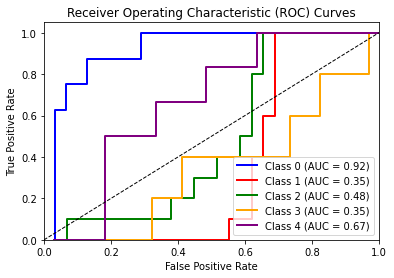

In [25]:
draw_roc_multi_curves(y_true_binary, y_scores, n_classes=5)

In [26]:
from sklearn.metrics import classification_report

In [27]:
cr = classification_report(y_test, final_model.predict(X_test))
print(cr)

              precision    recall  f1-score   support

        alaa       1.00      1.00      1.00         8
     aya amr       0.90      0.90      0.90        10
   aya sameh       0.90      0.90      0.90        10
        ehab       1.00      0.80      0.89         5
      salman       0.86      1.00      0.92         6

    accuracy                           0.92        39
   macro avg       0.93      0.92      0.92        39
weighted avg       0.93      0.92      0.92        39



In [28]:
def predictor(image_path, mean_face, eigvecs):
    gray_img = cv2.imread(image_path,0)
    face = face_detection(gray_img)
    pixel_values = []
    
    for (x, y, w, h) in face:
        face_img = gray_img[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (100,100))
        gray_pixels = face_img.flatten().tolist()
        
    pixel_values.append(gray_pixels)
    
    pixel_values = pd.DataFrame(pixel_values)
    
    X = np.array(pixel_values).reshape(len((pixel_values)), -1).astype(np.float64)
    
    X = X-mean_face
    X_pca = np.dot(X,eigvecs.T)
    
    pred = final_model.predict(X_pca)
    
    print(pred)


In [30]:
predictor("test/IMG-20230517-WA0034.jpg", mean_face, eigvecs)

['aya sameh']


[[293 147 535 535]]


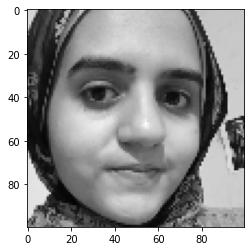

In [31]:
gray_img = cv2.imread("test/IMG-20230517-WA0034.jpg",0)
face = face_detection(gray_img)
print(face)
counter = 0
for (x, y, w, h) in face:
    face_img = gray_img[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, (100,100))
    plt.imshow(face_img, cmap="gray")
    counter+=1
    if counter == 2 :
        break

In [ ]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)